In [1]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
store_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/GitHub/Data-weak4/Data/rossmann-store-sales/store.csv', low_memory=False)
train_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/GitHub/Data-weak4/Data/rossmann-store-sales/train.csv', low_memory=False)
test_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/GitHub/Data-weak4/Data/rossmann-store-sales/test.csv', low_memory=False)
sample_submission = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/GitHub/Data-weak4/Data/rossmann-store-sales/sample_submission.csv', low_memory=False)


In [6]:
# Merge train and store data
train_data = train_data.merge(store_data, on='Store', how='left')

In [7]:
print(train_data.head())
print(train_data.columns)

   Store  DayOfWeek        Date  Sales  Customers  Open  Promo StateHoliday  \
0      1          5  2015-07-31   5263        555     1      1            0   
1      2          5  2015-07-31   6064        625     1      1            0   
2      3          5  2015-07-31   8314        821     1      1            0   
3      4          5  2015-07-31  13995       1498     1      1            0   
4      5          5  2015-07-31   4822        559     1      1            0   

   SchoolHoliday StoreType Assortment  CompetitionDistance  \
0              1         c          a               1270.0   
1              1         a          a                570.0   
2              1         a          a              14130.0   
3              1         c          c                620.0   
4              1         a          a              29910.0   

   CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  \
0                        9.0                    2008.0       0   
1                   

In [8]:
# Group by Date and sum the sales
daily_sales = train_data.groupby('Date')['Sales'].sum().reset_index()

# Convert Date to datetime format
daily_sales['Date'] = pd.to_datetime(daily_sales['Date'])
daily_sales.set_index('Date', inplace=True)

print(daily_sales.head())

              Sales
Date               
2013-01-01    97235
2013-01-02  6949829
2013-01-03  6347820
2013-01-04  6638954
2013-01-05  5951593


In [9]:
from statsmodels.tsa.stattools import adfuller

def check_stationarity(data):
    result = adfuller(data)
    return result[1]  # p-value

In [10]:
p_value = check_stationarity(daily_sales['Sales'])
print('P-Value:', p_value)

P-Value: 6.436731330559227e-05


In [11]:
if p_value > 0.05:
    daily_sales['Sales'] = daily_sales['Sales'].diff().dropna()

In [20]:
print(train_data.columns)

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')


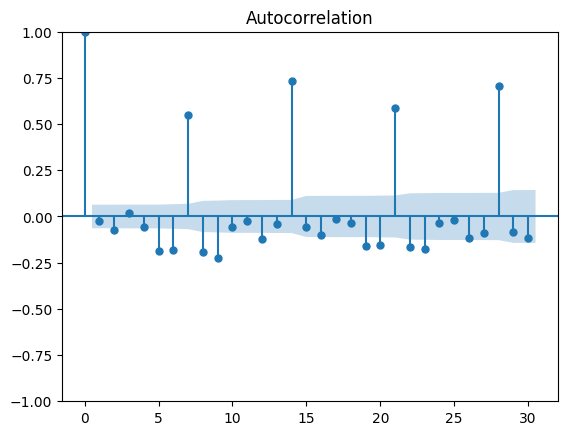

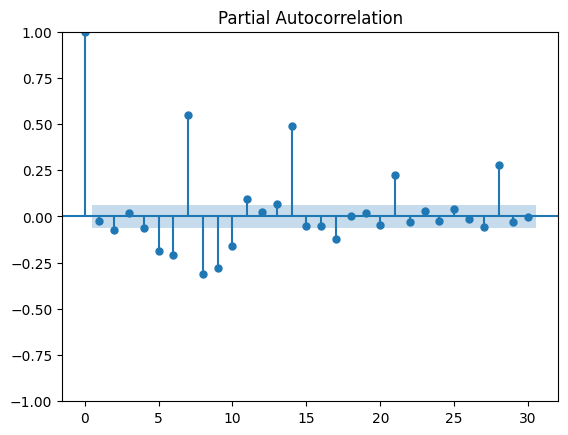

In [12]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(daily_sales['Sales'].dropna())
plt.title('Autocorrelation')
plt.show()

plot_pacf(daily_sales['Sales'].dropna())
plt.title('Partial Autocorrelation')
plt.show()

In [13]:
import numpy as np

def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

In [14]:
# Convert to numpy array
sales_array = daily_sales['Sales'].values
sales_array = sales_array.reshape(-1, 1)


In [15]:
# Create the dataset
time_step = 10  # Example window size
X, y = create_dataset(sales_array, time_step)
X = X.reshape(X.shape[0], X.shape[1], 1)  # Reshape for LSTM

In [16]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
sales_scaled = scaler.fit_transform(sales_array)

In [17]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(1))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [18]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [19]:
model.fit(X, y, epochs=50, batch_size=32)

Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 47655019347968.0000
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 49472881033216.0000
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 48212203274240.0000
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 49439578259456.0000
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 48248966348800.0000
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 48102257983488.0000
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 48398552006656.0000
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 49030130302976.0000
Epoch 9/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 48775213088768.0000
Epoch 10/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 50203730116608.0000
Epoch 11/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 49966521253888.0000
Epoch 12/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 49400726421504.0000
Epoch 13/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/st